# Gradient Boosting

Le notebook explore l'algorithme du [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Premier exemple

On considère les paramètres par défaut de la classe [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor).

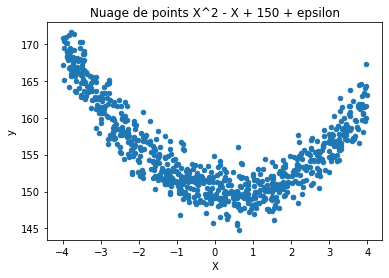

In [3]:
from numpy.random import randn, random
from pandas import DataFrame
from sklearn.model_selection import train_test_split
rnd = randn(1000)
X = random(1000) * 8 - 4
y = X ** 2 - X + rnd * 2 + 150 # X^2 - X + 150 + epsilon
X = X.reshape((-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y)
df = DataFrame({'X': X_train.ravel(), 'y': y_train})
ax = df.plot(x='X', y='y', kind='scatter')
ax.set_title("Nuage de points X^2 - X + 150 + epsilon");

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(max_depth=1)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

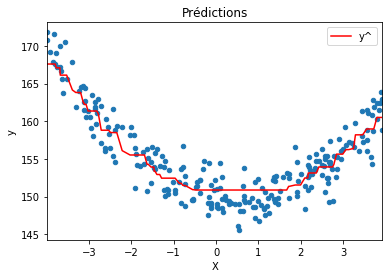

In [5]:
import numpy
ind = numpy.argsort(X_test, axis=0)
y_ = model.predict(X_test)
df = DataFrame({'X': X_test[ind].ravel(), 
                'y': y_test[ind].ravel(),
                'y^': y_[ind].ravel()})
ax = df.plot(x='X', y='y', kind='scatter')
df.plot(x='X', y='y^', kind='line', ax=ax, color="r")
ax.set_title("Prédictions");

Rien d'imprévu jusque là. Essayons autre chose.

In [6]:
model.estimators_.shape

(100, 1)

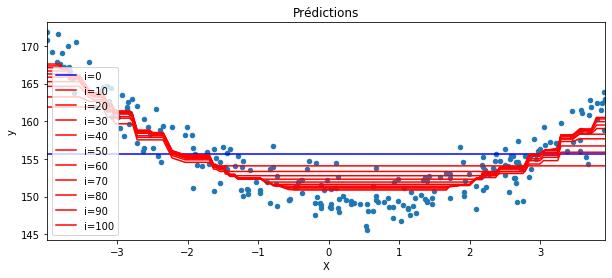

In [7]:
for i in range(0, model.estimators_.shape[0] + 1, 10):
    if i == 0:
        df = DataFrame({'X': X_test[ind].ravel(),
                        'y': y_test[ind].ravel()})
        ax = df.plot(x='X', y='y', kind='scatter', figsize=(10, 4))
        y_ = model.init_.predict(X_test)
        color = 'b'
    else:
        y_ = sum([model.init_.predict(X_test)] + 
                 [model.estimators_[k, 0].predict(X_test) * model.learning_rate
                  for k in range(0, i)])
        color = 'r'
    df = DataFrame({'X': X_test[ind].ravel(),
                    'y^': y_[ind].ravel()})
    df.plot(x='X', y='y^', kind='line', ax=ax, color=color, label='i=%d' % i)
ax.set_title("Prédictions");

## learning rate

Et si on choisissait un *learning_rate*, plus petit ou plus grand...

In [8]:
model01 = GradientBoostingRegressor(max_depth=1, learning_rate=0.01)
model01.fit(X_train, y_train)
modela = GradientBoostingRegressor(max_depth=1, learning_rate=1.2)
modela.fit(X_train, y_train)
modelb = GradientBoostingRegressor(max_depth=1, learning_rate=1.99)
modelb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.99, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

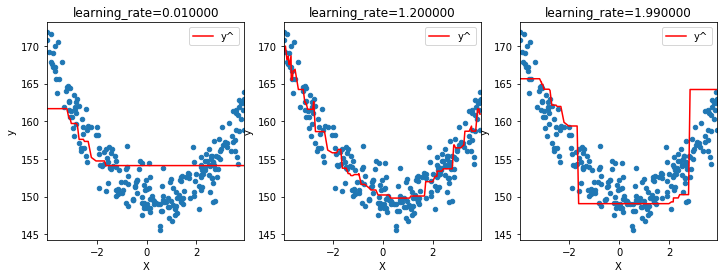

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ind = numpy.argsort(X_test, axis=0)

for i, mod in enumerate([model01, modela, modelb]):
    df = DataFrame({'X': X_test[ind].ravel(), 
                    'y': y_test[ind].ravel(),
                    'y^': mod.predict(X_test)[ind].ravel()})
    df.plot(x='X', y='y', kind='scatter', ax=ax[i])
    df.plot(x='X', y='y^', kind='line', ax=ax[i], color="r")
    ax[i].set_title("learning_rate=%f" % mod.learning_rate);

Une trop faible valeur de *learning_rate* semble retenir le modèle de converger, une grande valeur produit des effets imprévisibles. Pour comprendre pourquoi, il faut détailler l'algorithme...

## L'algorithme

Je reprends ici la page wikipedia. On cherche à construire un modèle qui minimise l'erreur $L(y,F(x)) = \sum_{i=1}^n l(y_i, F(X_i))$. On note $r$ le learning rate.

**Etape 1 :** on cale un premier modèle de régression, ici, simplement une constante, en optimisant $F_0(x) = \arg \min_\gamma \sum_{i=1}^n L(y_i, \gamma)$. $F_0(x)$ est une constante.

On note ensuite $F_m(x) = \gamma_0 \sum_{k=1}^m r \gamma_k h_k(x)$ où $\gamma_0$ est la fonction constante construire lors de la première étape.

**Etape 2 :** on calcule ensuite les erreurs $e_{im} = l(y_i, F_m(x_i))$ et l'opposé du gradient $r_{im} = - \left[ \frac{\partial l(y_i, F_m(x_i)) }{\partial F_m(x_i)} \right]$

**Etape 3 :** on choisit la fonction $h_{m+1}(x)$ de telle sorte qu'elle approxime au mieux les résidus $r_{im}$.

**Etape 4 :** on choisit le coefficient $\gamma_{m+1}$ de telle sorte qu'il minimise l'expression $\min_\gamma \sum_{i=1}^n l\left(y_i, \gamma_0 + \sum_{k=1}^m r \gamma_k h_k(x_i) + \gamma h_{m+1}(x_i)\right)$.

On retourne l'étape 2 autant de fois qu'il y a d'itérations. Lorsque l'erreur est une erreur quadratique $l(y, F(x)) = (y-F(x))^2$, les résidus deviennent $r_{im} = -2 (y_i - F_m(x_i))$. Par conséquent, la fonction $h$ approxime au mieux ce qu'il manque pour atteindre l'objectif. Un learning rate égal à 1 fait que la somme des prédictions de chaque fonction $h_m$ oscille autour de la vraie valeur, une faible valeur donne l'impression d'une fonction qui converge à petits pas, une grande valeur accroît l'amplitude des oscillations au point d'empêcher l'algorithme de converger.

## Régression quantile

Dans ce cas, l'erreur quadratique est remplacée par une erreur en valeur absolue. Les résidus dans ce cas sont égaux à -1 ou 1.

In [10]:
alpha = 0.5
model = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=0.1)
model.fit(X_train, y_train)
model01 = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=0.01)
model01.fit(X_train, y_train)
modela = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=1.2)
modela.fit(X_train, y_train)
modelb = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=1.99)
modelb.fit(X_train, y_train)
modelc = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=2.01)
modelc.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.5, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=2.01, loss='quantile',
                          max_depth=1, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

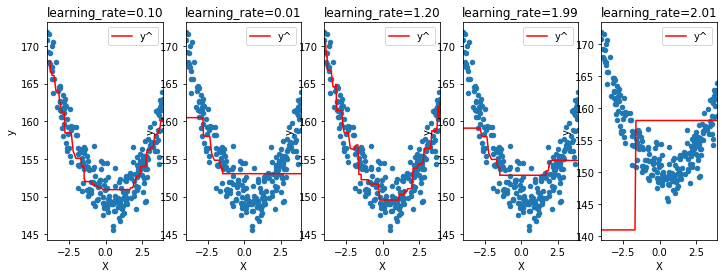

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
ind = numpy.argsort(X_test, axis=0)

for i, mod in enumerate([model, model01, modela, modelb, modelc]):
    df = DataFrame({'X': X_test[ind].ravel(), 
                    'y': y_test[ind].ravel(),
                    'y^': mod.predict(X_test)[ind].ravel()})
    df.plot(x='X', y='y', kind='scatter', ax=ax[i])
    df.plot(x='X', y='y^', kind='line', ax=ax[i], color="r")
    ax[i].set_title("learning_rate=%1.2f" % mod.learning_rate);

Concrètement, le paramètre *max_depth=1* correspond à une simple fonction $f(x) = \mathbb{1}_{x > s}$ et le modèle final est une somme pondérée de fonctions indicatrices.